# Feature Engineering Branch

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('transactions_dataset.csv', sep=";")

In [3]:
df['date_order'] = pd.to_datetime(df['date_order'], format='%Y-%m-%d')

In [4]:
#filtered_df = df.loc[(df['date_order'] >= '2018-01-01') & (df['date_order'] <= '2018-12-31')]
filtered_df = df.copy()

In [5]:
print(filtered_df['date_order'].min())
print(filtered_df['date_order'].max())

2017-09-22 00:00:00
2019-09-22 00:00:00


In [6]:
filtered_df.shape

(63319315, 8)

In [7]:
filtered_df.drop_duplicates()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155.44320,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16.39440,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,365.76624,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,8.59878,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093.37400,3,by phone,7051
...,...,...,...,...,...,...,...,...
63319310,2019-06-10,2020-06-12,1596284,245272,-2056.91300,5,by phone,7682
63319311,2018-12-14,2020-07-15,908253,880496,27.62760,1001,by phone,9375
63319312,2019-07-26,2020-10-29,1168247,2063314,-204.60984,101,by phone,3014
63319313,2018-05-23,2020-11-27,2319965,1287654,70.49730,17,by phone,1015


In [8]:
filtered_df = filtered_df.drop(['date_invoice'],axis=1)

In [9]:
filtered_df = filtered_df.drop(['order_channel'],axis=1)

In [10]:
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
4,2017-09-25,203377,2086861,1093.37400,3,7051


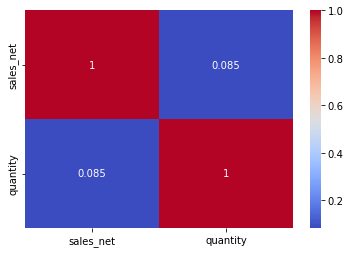

In [11]:
sns.heatmap(data=filtered_df[['date_order', 'sales_net','quantity']].corr(),
            annot=True, cmap='coolwarm');

In [13]:
# Checking for outliers

cols_for_distrib = ['sales_net','quantity']

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(filtered_df,x)[2]}")

sales_net: 4411763
quantity: 9812964


# Outlier Detection

<AxesSubplot:ylabel='sales_net'>

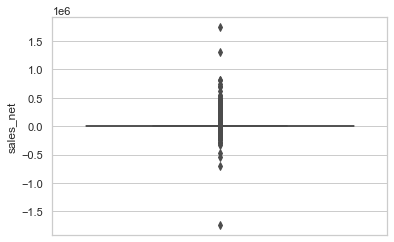

In [14]:
sns.set(style="whitegrid")
sns.boxplot(y=filtered_df['sales_net'])

<AxesSubplot:ylabel='quantity'>

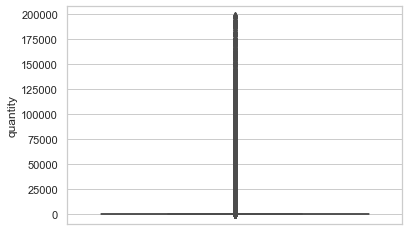

In [15]:
sns.set(style="whitegrid")
sns.boxplot(y=df['quantity'])

# Removing Outliers for sales_net

In [16]:
filtered_df = filtered_df[(filtered_df['sales_net'] > outlier_function(filtered_df,'sales_net')[0]) &
              (filtered_df['sales_net'] < outlier_function(filtered_df,'sales_net')[1])]
filtered_df.head()

,date_order,product_id,client_id,sales_net,quantity,branch_id
0,2017-09-25,2376333,188502,155.44320,3,2732
1,2017-09-25,2520527,835089,16.39440,3,10279
2,2017-09-25,2536756,1977896,365.76624,21,6184
3,2017-09-25,3028673,598816,8.59878,201,4200
5,2017-09-25,793319,564878,116.70384,11,35


In [17]:
filtered_df.shape

(58907546, 6)

In [18]:
filtered_df.nunique()

date_order        731
product_id     411447
client_id      168416
sales_net     1307082
quantity         2329
branch_id         576
dtype: int64

In [19]:
#Calculating Recency

df_recency = filtered_df.groupby(by='branch_id',
                        as_index=False)['date_order'].max()
df_recency.columns = ['branch_id', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,branch_id,LastPurchaseDate,Recency
0,20,2019-09-20,2
1,23,2017-12-19,642
2,35,2019-09-20,2
3,81,2019-09-20,2
4,83,2019-09-09,13


In [20]:
df_recency.shape

(576, 3)

In [21]:
#Calculating Frequency
frequency_df = filtered_df.groupby(
    by=['branch_id'], as_index=False)['date_order'].nunique()
frequency_df.columns = ['branch_id', 'Frequency']
frequency_df.head()

,branch_id,Frequency
0,20,561
1,23,1
2,35,512
3,81,529
4,83,148


In [22]:
frequency_df.shape

(576, 2)

In [23]:
#Calculating Monetary Value
monetary_df = filtered_df.groupby(by='branch_id', as_index=False)['sales_net'].sum()
monetary_df.columns = ['branch_id', 'Monetary']
monetary_df.head()

,branch_id,Monetary
0,20,9.829685e+06
1,23,8.433180e+02
2,35,1.120361e+07
3,81,4.245500e+06
4,83,1.667414e+05


In [24]:
monetary_df.shape

(576, 2)

In [25]:
monetary_df['Monetary']=monetary_df['Monetary'].astype('int64')

In [26]:
monetary_df.dtypes

branch_id    int64
Monetary     int64
dtype: object

In [27]:
#Merging all three columns in one dataframe
rf_df = df_recency.merge(frequency_df, on='branch_id')
rfm_df = rf_df.merge(monetary_df, on='branch_id').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,branch_id,Recency,Frequency,Monetary
0,20,2,561,9829685
1,23,642,1,843
2,35,2,512,11203606
3,81,2,529,4245499
4,83,13,148,166741


In [28]:
rfm_table = rfm_df.copy()

In [29]:
df_lifespam_max = filtered_df.groupby(by='branch_id',
                        as_index=False)['date_order'].max()
df_lifespam_max.columns = ['branch_id', 'LastPurchaseDate']

In [30]:
df_lifespam_max.head()

,branch_id,LastPurchaseDate
0,20,2019-09-20
1,23,2017-12-19
2,35,2019-09-20
3,81,2019-09-20
4,83,2019-09-09


In [31]:
df_lifespam_max.shape

(576, 2)

In [32]:
df_lifespam_min = filtered_df.groupby(by='branch_id',
                        as_index=False)['date_order'].min()
df_lifespam_min.columns = ['branch_id', 'FirstPurchaseDate']
df_lifespam_min.head()

,branch_id,FirstPurchaseDate
0,20,2017-09-22
1,23,2017-12-19
2,35,2017-09-25
3,81,2017-09-25
4,83,2017-09-28


In [33]:
df_lifespam_min.shape

(576, 2)

In [34]:
df_lifespam = df_lifespam_max.merge(df_lifespam_min, on='branch_id')
df_lifespam.head()

,branch_id,LastPurchaseDate,FirstPurchaseDate
0,20,2019-09-20,2017-09-22
1,23,2017-12-19,2017-12-19
2,35,2019-09-20,2017-09-25
3,81,2019-09-20,2017-09-25
4,83,2019-09-09,2017-09-28


In [35]:
df_lifespam.dtypes

branch_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
dtype: object

In [36]:
df_lifespam.shape

(576, 3)

In [37]:
df_lifespam['lifespam'] = (df_lifespam['LastPurchaseDate'] - df_lifespam['FirstPurchaseDate'])

In [38]:
df_lifespam.head()

,branch_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,20,2019-09-20,2017-09-22,728 days
1,23,2017-12-19,2017-12-19,0 days
2,35,2019-09-20,2017-09-25,725 days
3,81,2019-09-20,2017-09-25,725 days
4,83,2019-09-09,2017-09-28,711 days


In [39]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype(str)

In [40]:
df_lifespam.head()

,branch_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,20,2019-09-20,2017-09-22,728 days
1,23,2017-12-19,2017-12-19,0 days
2,35,2019-09-20,2017-09-25,725 days
3,81,2019-09-20,2017-09-25,725 days
4,83,2019-09-09,2017-09-28,711 days


In [41]:
df_lifespam['lifespam'] = df_lifespam["lifespam"].str.split(" days").str[0].astype(int)

In [42]:
df_lifespam.head()

,branch_id,LastPurchaseDate,FirstPurchaseDate,lifespam
0,20,2019-09-20,2017-09-22,728
1,23,2017-12-19,2017-12-19,0
2,35,2019-09-20,2017-09-25,725
3,81,2019-09-20,2017-09-25,725
4,83,2019-09-09,2017-09-28,711


In [43]:
df_lifespam.dtypes

branch_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int32
dtype: object

In [44]:
df_lifespam['lifespam'] = df_lifespam['lifespam'].astype('int64')

In [45]:
df_lifespam.dtypes

branch_id                     int64
LastPurchaseDate     datetime64[ns]
FirstPurchaseDate    datetime64[ns]
lifespam                      int64
dtype: object

In [46]:
#Merging all three columns in one dataframe
rfm_lifespam = rfm_df.merge(df_lifespam, on='branch_id')
rfm_lifespam.head()

,branch_id,Recency,Frequency,Monetary,LastPurchaseDate,FirstPurchaseDate,lifespam
0,20,2,561,9829685,2019-09-20,2017-09-22,728
1,23,642,1,843,2017-12-19,2017-12-19,0
2,35,2,512,11203606,2019-09-20,2017-09-25,725
3,81,2,529,4245499,2019-09-20,2017-09-25,725
4,83,13,148,166741,2019-09-09,2017-09-28,711


In [47]:
rfm_lifespam.shape

(576, 7)

In [48]:
rfm_lifespam = rfm_lifespam.drop(['LastPurchaseDate', 'FirstPurchaseDate'], axis=1)
rfm_lifespam.head()

,branch_id,Recency,Frequency,Monetary,lifespam
0,20,2,561,9829685,728
1,23,642,1,843,0
2,35,2,512,11203606,725
3,81,2,529,4245499,725
4,83,13,148,166741,711


In [49]:
rfm_lifespam.shape

(576, 5)

In [50]:
rfm_lifespam.dtypes

branch_id    int64
Recency      int64
Frequency    int64
Monetary     int64
lifespam     int64
dtype: object

In [51]:
#Calculating CLV
clv_df = filtered_df.groupby(by='branch_id', as_index=False)['sales_net'].mean()
clv_df.columns = ['branch_id', 'monetary_avg']
clv_df.head()

,branch_id,monetary_avg
0,20,67.525023
1,23,210.829500
2,35,97.171706
3,81,74.408045
4,83,63.472179


In [52]:
clv_df['monetary_avg']=clv_df['monetary_avg'].astype('int64')
clv_df.dtypes

branch_id       int64
monetary_avg    int64
dtype: object

In [53]:
clv_df.shape

(576, 2)

In [54]:
#Merging all three columns in one dataframe
clv = clv_df.merge(frequency_df, on='branch_id')
clv.head()

,branch_id,monetary_avg,Frequency
0,20,67,561
1,23,210,1
2,35,97,512
3,81,74,529
4,83,63,148


In [55]:
clv['clv'] = clv['monetary_avg'] * clv['Frequency']
clv.head()

,branch_id,monetary_avg,Frequency,clv
0,20,67,561,37587
1,23,210,1,210
2,35,97,512,49664
3,81,74,529,39146
4,83,63,148,9324


In [56]:
clv.shape

(576, 4)

In [57]:
del clv['Frequency']

In [58]:
clv.head()

,branch_id,monetary_avg,clv
0,20,67,37587
1,23,210,210
2,35,97,49664
3,81,74,39146
4,83,63,9324


In [59]:
rfm = rfm_lifespam.merge(clv, on='branch_id')
rfm.head()

,branch_id,Recency,Frequency,Monetary,lifespam,monetary_avg,clv
0,20,2,561,9829685,728,67,37587
1,23,642,1,843,0,210,210
2,35,2,512,11203606,725,97,49664
3,81,2,529,4245499,725,74,39146
4,83,13,148,166741,711,63,9324


In [60]:
del rfm['monetary_avg']

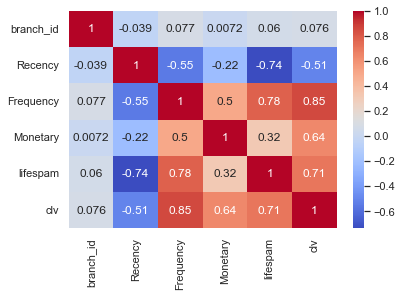

In [61]:
sns.heatmap(data=rfm[['branch_id', 'Recency','Frequency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [62]:
rfm1 = rfm.copy()

In [63]:
# Dropping Frequency column
del rfm1['Frequency']

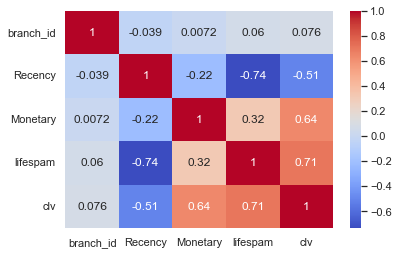

In [64]:
sns.heatmap(data=rfm[['branch_id', 'Recency','Monetary','lifespam','clv']].corr(),
            annot=True, cmap='coolwarm');

In [65]:
# Checking for outliers

cols_for_distrib = ['branch_id', 'Recency','Monetary','lifespam','clv']

def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

for x in cols_for_distrib:
    print(f"{x}: {outlier_function(rfm1,x)[2]}")

branch_id: 0
Recency: 168
Monetary: 9
lifespam: 94
clv: 41


<AxesSubplot:ylabel='Recency'>

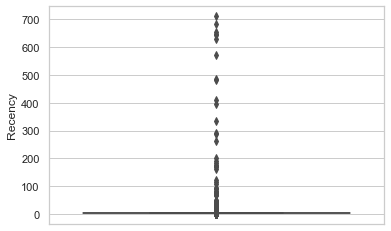

In [66]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['Recency']) #no outliers was removed 

<AxesSubplot:ylabel='lifespam'>

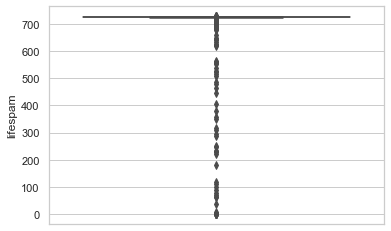

In [67]:
sns.set(style="whitegrid")
sns.boxplot(y=rfm1['lifespam']) #no outliers was removed

<AxesSubplot:xlabel='Monetary', ylabel='clv'>

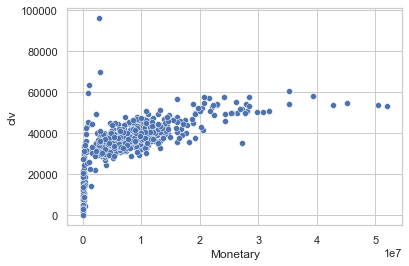

In [68]:
sns.scatterplot(x=rfm1['Monetary'], y=rfm1['clv'])

# Defining Churn

In [71]:
print(rfm1.Recency.min(),
rfm1.Recency.max(),
rfm1.Recency.quantile(0.25),
rfm1.Recency.quantile(0.5), 
rfm1.Recency.quantile(0.75)) #More than 75% of our branches have a recency = 2 so therefore recency will not be considered in the analysis

0 711 2.0 2.0 2.0


In [72]:
del rfm1['Recency']

In [73]:
print(rfm1.lifespam.min(),
rfm1.lifespam.max(),
rfm1.lifespam.quantile(0.25),
rfm1.lifespam.quantile(0.5), 
rfm1.lifespam.quantile(0.75)) #25% 50% and 75% of our branches have a lifespan - 725&726 so therefore lifespan will not be considered in the analysis

0 729 725.0 725.0 726.0


In [74]:
del rfm1['lifespam']

In [75]:
def score(x,p,d):
    if x <= d[p][0.25]:
        return 1
    if x <= d[p][0.5] and x >d[p][0.25]:
        return 2
    if x <= d[p][0.75] and x >d[p][0.5]: 
        return 3
    if x >d[p][0.75]:
        return 4

In [76]:
quantiles = rfm1.quantile(q=[0.25,0.50,0.75])
quantiles

,branch_id,Monetary,clv
0.25,2643.5,3276150.5,31606.25
0.50,5174.0,6288073.0,36253.50
0.75,8592.5,9925262.5,40838.00


In [77]:
quantiles = quantiles.to_dict()
rfm1['clv_Tile'] = rfm1['clv'].apply(score, args=('clv',quantiles))

In [78]:
rfm1['clv_Tile'].value_counts()

3    144
1    144
4    144
2    144
Name: clv_Tile, dtype: int64

In [79]:
rfm1['Mone_Tile'] = rfm1['Monetary'].apply(score, args=('Monetary',quantiles,))
rfm1['Mone_Tile'].value_counts()

3    144
1    144
4    144
2    144
Name: Mone_Tile, dtype: int64

In [80]:
# Add to dataframe
rfm1['score_v1'] = rfm1['clv_Tile'].map(str) + rfm1['Mone_Tile'].map(str)
rfm1.head()

,branch_id,Monetary,clv,clv_Tile,Mone_Tile,score_v1
0,20,9829685,37587,3,3,33
1,23,843,210,1,1,11
2,35,11203606,49664,4,4,44
3,81,4245499,39146,3,2,32
4,83,166741,9324,1,1,11


In [81]:
rfm1.score_v1.min()

'11'

In [82]:
#Who are the lost branches?

#Customers who's recency, frequency as well as monetary values are low 

rfm1[rfm1['score_v1'] == '11'].count()

branch_id    102
Monetary     102
clv          102
clv_Tile     102
Mone_Tile    102
score_v1     102
dtype: int64

In [83]:
#Summing the RFM Score
rfm1['score'] = rfm1[['clv_Tile','Mone_Tile']].sum(axis=1)
rfm1.head()

,branch_id,Monetary,clv,clv_Tile,Mone_Tile,score_v1,score
0,20,9829685,37587,3,3,33,6
1,23,843,210,1,1,11,2
2,35,11203606,49664,4,4,44,8
3,81,4245499,39146,3,2,32,5
4,83,166741,9324,1,1,11,2


In [84]:
print(rfm1.score.mean(),
rfm1.score.median(),
rfm1.score.max(),
rfm1.score.min(),     
rfm1.score.quantile(0.25),
rfm1.score.quantile(0.5), 
rfm1.score.quantile(0.75))

5.0 5.0 8 2 3.0 5.0 7.0


In [85]:
def score_level(df):
    if df['score']<=3:
        return 'Churned'
    if df['score'] >3 and df['score'] <=5:
        return 'Regular'
    if df['score'] >5 and df['score'] <=7:
        return 'Loyal'
    if df['score'] >7:
        return 'Premium'

In [86]:
# Create a new variable RFM_Level
rfm1['score_level'] = rfm1.apply(score_level, axis=1)

# Print the header with top 5 rows to the console
rfm1.head()

,branch_id,Monetary,clv,clv_Tile,Mone_Tile,score_v1,score,score_level
0,20,9829685,37587,3,3,33,6,Loyal
1,23,843,210,1,1,11,2,Churned
2,35,11203606,49664,4,4,44,8,Premium
3,81,4245499,39146,3,2,32,5,Regular
4,83,166741,9324,1,1,11,2,Churned


In [87]:
rfm1.to_csv('branch_clustering_2.csv', sep=',', index = False)

In [88]:
rfm1["score_level"].value_counts()

Regular    176
Churned    160
Loyal      145
Premium     95
Name: score_level, dtype: int64

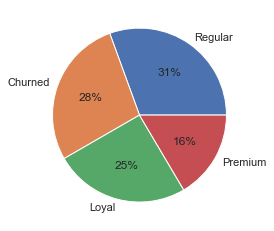

In [89]:
plt.pie(rfm1.score_level.value_counts(),
        labels=rfm1.score_level.value_counts().index,
        autopct='%.0f%%')
plt.show()